In [1]:
import pandas as pd
import numpy as np
raw_data = pd.read_csv('./data/sentiment_word_tagging_train.csv', header=None, delimiter='\t')
str(raw_data.iloc[0].values[0])

'给/N 妈/N 妈/N 买/N 的/N ，/N 妈/N 妈/N 很/N 满/B 意/E 。/N'

In [2]:
s = ''
for index, row in raw_data.iterrows():
    if index != 0:
        s = s + ' '
    s = s + row.values[0]

In [3]:
import re
import tqdm
sentences = re.split(u'[，。！？、‘’“”]/[BMENS]', s)

def get_Xy(sentence):
    """将 sentence 处理成 [word1, w2, ..wn], [tag1, t2, ...tn]"""
    words_tags = re.findall('(.)/(.)', sentence)
    if words_tags:
        words_tags = np.asarray(words_tags)
        words = words_tags[:, 0]
        tags = words_tags[:, 1]
        return words, tags # 所有的字和tag分别存为 data / label
    return None

datas = []
labels = []
for sentence in iter(sentences):
    res = get_Xy(sentence)
    if res:
        datas.append(res[0])
        labels.append(res[1])

In [4]:
df_data = pd.DataFrame({'words': datas, 'tags': labels}, index=range(len(datas)))
#　句子长度
df_data['sentence_len'] = df_data['words'].apply(lambda words: len(words))
df_data.head(2)

,tags,words,sentence_len
0,"[N, N, N, N, N]","[给, 妈, 妈, 买, 的]",5
1,"[N, N, N, B, E]","[妈, 妈, 很, 满, 意]",5


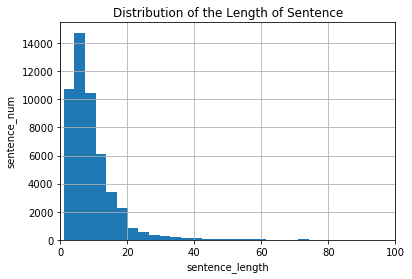

In [5]:
import matplotlib.pyplot as plt
df_data['sentence_len'].hist(bins=100)
plt.xlim(0, 100)
plt.xlabel('sentence_length')
plt.ylabel('sentence_num')
plt.title('Distribution of the Length of Sentence')
plt.show()

In [6]:
from itertools import chain
all_words = list(chain(*df_data['words'].values))


In [65]:
from keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer(lower=False)
tokenizer.fit_on_texts(all_words)

In [73]:
tokenizer.word_index

{'的': 1,
 '不': 2,
 '了': 3,
 '是': 4,
 '一': 5,
 '好': 6,
 '很': 7,
 '用': 8,
 '有': 9,
 '还': 10,
 '就': 11,
 '买': 12,
 '没': 13,
 '个': 14,
 '这': 15,
 '也': 16,
 '我': 17,
 '错': 18,
 '来': 19,
 '到': 20,
 '以': 21,
 '货': 22,
 '上': 23,
 '都': 24,
 '大': 25,
 '点': 26,
 '可': 27,
 '在': 28,
 '么': 29,
 '太': 30,
 '后': 31,
 '装': 32,
 '东': 33,
 '差': 34,
 '品': 35,
 '过': 36,
 '次': 37,
 '感': 38,
 '觉': 39,
 '看': 40,
 '子': 41,
 '价': 42,
 '质': 43,
 '说': 44,
 '发': 45,
 '小': 46,
 '能': 47,
 '果': 48,
 '时': 49,
 '比': 50,
 '要': 51,
 '多': 52,
 '天': 53,
 '电': 54,
 '量': 55,
 '评': 56,
 '快': 57,
 '道': 58,
 '给': 59,
 '人': 60,
 '挺': 61,
 '得': 62,
 '家': 63,
 '但': 64,
 '服': 65,
 '机': 66,
 '意': 67,
 '西': 68,
 '下': 69,
 '样': 70,
 '实': 71,
 '手': 72,
 '味': 73,
 '包': 74,
 '物': 75,
 '送': 76,
 '度': 77,
 '面': 78,
 '真': 79,
 '满': 80,
 '效': 81,
 'l': 82,
 '般': 83,
 '开': 84,
 '会': 85,
 '0': 86,
 '常': 87,
 '1': 88,
 '便': 89,
 '行': 90,
 '吧': 91,
 '本': 92,
 '现': 93,
 '和': 94,
 '喜': 95,
 '里': 96,
 '欢': 97,
 '那': 98,
 '收': 99,
 '为': 100,
 '出': 10

In [36]:
from keras.preprocessing.sequence import pad_sequences
def word_to_index(sentence):
    tmp = tokenizer.texts_to_sequences(sentence)
    res = []
    for i in tmp:
        if i:
            res.append(i[0])
    return [res]

df_data['X'] = df_data['words'].apply(word_to_index)


In [48]:
df_data['Y'] = df_data['tags'].apply(word_to_index)

In [37]:
df_data['X'] = df_data['X'].apply(pad_sequences, args=[40, 'int32', 'post'])

In [50]:
df_data['Y'] = df_data['Y'].apply(pad_sequences, args=[40, 'int32', 'post'])

In [54]:
X = np.asarray(list(df_data['X'].values))
y = np.asarray(list(df_data['Y'].values))

In [59]:
X = X.reshape(X.shape[0], X.shape[2])
y = y.reshape(y.shape[0], y.shape[2])

In [61]:
y

array([[374, 374, 374, ...,   0,   0,   0],
       [374, 374, 374, ...,   0,   0,   0],
       [374, 374, 374, ...,   0,   0,   0],
       ..., 
       [374, 374, 374, ...,   0,   0,   0],
       [374, 374, 269, ...,   0,   0,   0],
       [374, 374, 374, ...,   0,   0,   0]])